# Developing the basic expoeriment pipeline

Based on the dummy regressor that always predicts the constant confidence interval based on 5% and 95% quantiles of the target.


In [1]:
import joblib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading the data
X_train = np.load("../datasets/simple/X_train.npy")
y_train = np.load("../datasets/simple/y_train.npy")
target_scaler = joblib.load("../datasets/simple/target_scaler.save")

# Dummy regressor


In [3]:
class DummyModel:
    def __init__(self):
        self.confidence_interval = None

    def fit(self, X: np.array, y: np.array) -> None:
        self.confidence_interval = np.quantile(y, [0.05, 0.95])

    def predict(self, X: np.array) -> np.array:
        if self.confidence_interval is None:
            raise RuntimeError("Model not fitted")
        return np.tile(self.confidence_interval, (X.shape[0], 1))


model = DummyModel()
model.fit(X_train, y_train)

# Analysis utils


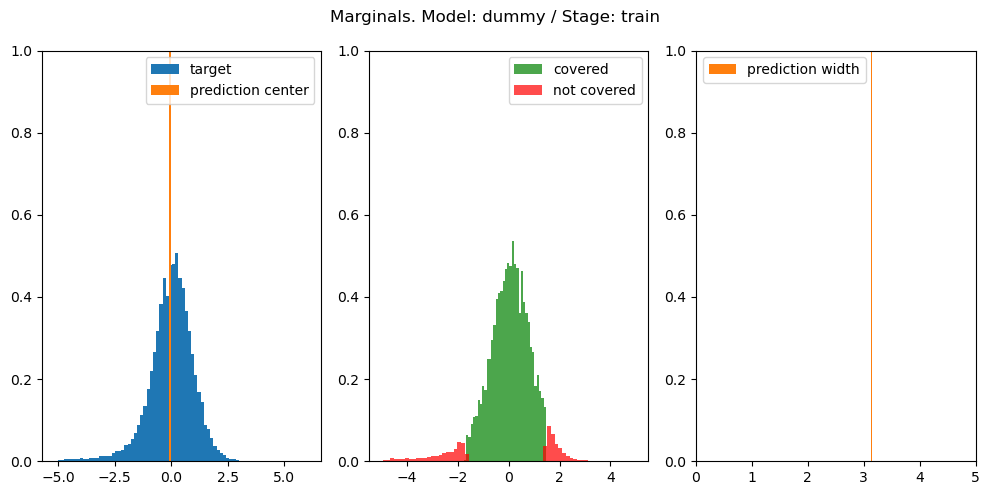

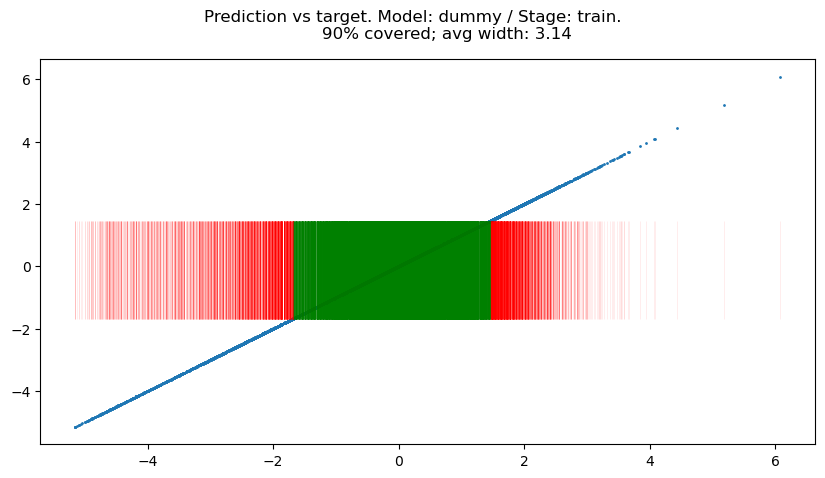

In [13]:
from pathlib import Path


class Analysis:
    def __init__(
        self,
        y: np.array,
        y_pred: np.array,
        stage: str,
        model_name: str,
        save_path: str = None,
    ) -> None:
        idxs_sorted = np.argsort(y, axis=0).flatten()
        self.y = y[idxs_sorted].flatten()
        self.y_pred = y_pred[idxs_sorted]
        self.is_covered = (self.y_pred[:, 0] <= self.y) & (self.y <= self.y_pred[:, 1])
        self.percent_covered = int(self.is_covered.mean() * 100)
        self.avg_width = (self.y_pred[:, 1] - self.y_pred[:, 0]).mean()

        self.stage = stage
        self.model_name = model_name
        self.save_path = save_path

        self.bins = 80
        color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        self.target_color = color_cycle[0]
        self.prediction_color = color_cycle[1]
        self.covered_color = "green"
        self.not_covered_color = "red"

    def marginals(self):
        """Show marginal distributions for target values, prediction interval means, and
        prediction interval widths."""
        y_pred_center = self.y_pred.mean(axis=1)
        y_pred_width = self.y_pred[:, 1] - self.y_pred[:, 0]

        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

        axs[0].hist(
            self.y,
            bins=self.bins,
            density=True,
            label="target",
            color=self.target_color,
        )
        axs[0].hist(
            y_pred_center,
            density=False,
            bins=self.bins
            if y_pred_center.std() > 1e-5
            else 10,  # account for point masses
            label="prediction center",
            color=self.prediction_color,
        )

        self._plot_partial_histogram(
            axs[1], self.is_covered, "covered", self.covered_color
        )
        self._plot_partial_histogram(
            axs[1], ~self.is_covered, "not covered", self.not_covered_color
        )

        axs[2].hist(
            y_pred_width,
            density=True,
            bins=self.bins,
            label="prediction width",
            color=self.prediction_color,
        )
        axs[2].set_xlim((0, 5))

        for ax in axs:
            ax.legend()
            ax.set_ylim((0, 1))
        plt.suptitle(f"Marginals. Model: {self.model_name} / Stage: {self.stage}")
        plt.tight_layout()
        self._save_fig(fig, "marginals")
        plt.show()

    def target_vs_predicted(self):
        """Show prediction intervals against sorted target values."""
        fig, ax = plt.subplots(figsize=(10, 5))
        colors = np.where(self.is_covered, self.covered_color, self.not_covered_color)
        ax.vlines(
            self.y,
            self.y_pred[:, 0],
            self.y_pred[:, 1],
            colors=colors,
            alpha=0.1,
            linewidth=0.5,
        )
        ax.scatter(self.y, self.y, color=self.target_color, s=1)

        plt.suptitle(
            f"""Prediction vs target. Model: {self.model_name} / Stage: {self.stage}. 
            {self.percent_covered}% covered; avg width: {self.avg_width:.2f}"""
        )
        self._save_fig(fig, "target-vs-predicted")
        plt.show()

    def _plot_partial_histogram(self, ax, mask, label, color):
        """Like ax.hist, but normalization is done with respect to the total length.

        Using ax.hist directly on a masked array with density=True would normalize the
        result, independently of the fraction of examples that are masked. This function
        uses a workaround by filling the masked values with a dummy value, which is
        hidden away by xlim."""
        dummy_value = -5.7
        y_masked = self.y.copy()
        y_masked[~mask] = dummy_value
        ax.hist(
            y_masked,
            bins=self.bins,
            density=True,
            label=label,
            color=color,
            alpha=0.7,
        )
        ax.set_xlim((-5.5, 5.5))

    def _save_fig(self, fig, name):
        if self.save_path is None:
            return
        file_path = Path(self.save_path, f"{self.model_name}_{self.stage}_{name}.png")
        fig.savefig(file_path)


analysis = Analysis(
    y_train[::2], model.predict(X_train[::2]), "train", "dummy", save_path='.'
)
analysis.marginals()
analysis.target_vs_predicted()